In [24]:
#Load those libraries!
import time
import threading
import logging
import retro
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import initializers
from keras import backend as K

from sklearn.preprocessing import scale
import numpy as np
import cv2
import numpy as np
#import keyboard
import gym
import matplotlib.pylab as plt
from matplotlib.gridspec import GridSpec
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure

from IPython.display import clear_output
#retro.data.list_games()

In [ ]:
#Run this line if you want to see what games are available. 
#retro.data.list_games()

In [25]:
#obs, rew, done, info = env.step(env.action_space.sample())
#(224, 240, 3)
#MultiBinary(9)                          
class RAM_ANN():
  def __init__(self, action_space, state_space, frameskip, seed):
    self.seed = seed
    initializer1 = initializers.GlorotUniform (seed = self.seed+1)
    initializer2 = initializers.GlorotUniform (seed = self.seed+2)
    initializer3 = initializers.GlorotUniform (seed = self.seed+3)
    initializer4 = initializers.GlorotUniform (seed = self.seed+4)
    self.frameskip = frameskip
    self.action_space = len(action_space)
    num_actions = self.action_space
    #NN layers
    ram_input = layers.Input(shape=(state_space))
    #preprocessor = layers.experimental.preprocessing.Resizing(84, 84, interpolation='bilinear', name=None)(image_input)
    # Convolutions on the frames on the screen
    #data_format='channels_first'
    
    layer5 = layers.Dense(128, activation="relu", kernel_initializer = initializer1)(ram_input)
    layer6 = layers.Dense(512, activation="relu", kernel_initializer = initializer2)(layer5)
    layer7 = layers.Dense(128, activation="relu", kernel_initializer = initializer3)(layer6)
    action = layers.Dense(num_actions, activation="linear", kernel_initializer = initializer4)(layer7)

    #Define NN parameters.
    self.toymodel = keras.Model(inputs=ram_input, outputs=action)
    self.loss_fn = tf.keras.losses.Huber()
    self.optimizer = keras.optimizers.Adam(learning_rate=0.0000625, clipnorm=1.0)
    self.toymodel.compile(self.optimizer, self.loss_fn)

  def trainStep(self, sample_X, sample_Y):
    with tf.GradientTape() as tape:
      old_q = self.toymodel(sample_X, training=True)
      loss_value = self.loss_fn(sample_Y, old_q)
    grads = tape.gradient(loss_value, self.toymodel.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.toymodel.trainable_weights))
    return loss_value.numpy()

  def train(self, x_input, y_input, batchsize=64):
    loss_history = []
    dataset = tf.data.Dataset.from_tensor_slices((x_input, y_input))
    dataset = dataset.shuffle(buffer_size=1024).batch(batchsize)
    for steps, (x, y) in enumerate(dataset):
      loss_history.append(self.trainStep(x,y))
    return loss_history

  def forward(self, x_input):
    return self.toymodel(x_input)

class A2C():
  def __init__(self, action_space, state_space, frameskip, seed):
    self.seed = seed
    initializer1 = initializers.GlorotUniform (seed = self.seed+1)
    initializer2 = initializers.GlorotUniform (seed = self.seed+2)
    initializer3 = initializers.GlorotUniform (seed = self.seed+3)
    initializer4 = initializers.GlorotUniform (seed = self.seed+4)
    self.frameskip = frameskip
    self.action_space = len(action_space)
    self.num_actions = self.action_space
    self.state_space = state_space
    #NN layers
    ram_input = layers.Input(shape=(self.state_space))
    #preprocessor = layers.experimental.preprocessing.Resizing(84, 84, interpolation='bilinear', name=None)(image_input)
    # Convolutions on the frames on the screen
    #data_format='channels_first'
    layer5 = layers.Dense(256, activation="relu", kernel_initializer = initializer1)(ram_input)
    logaction = layers.Dense(self.num_actions, activation="linear", kernel_initializer = initializer2)(layer5)
    value = layers.Dense(1, activation="linear", kernel_initializer = initializer3)(layer5)

    #Define NN parameters.
    self.toymodel = keras.Model(inputs=ram_input, outputs=[logaction, value])
    self.loss_fn = tf.keras.losses.MeanSquaredError()
    self.optimizer = keras.optimizers.Adam(learning_rate=0.0001)
    self.toymodel.compile(self.optimizer, self.loss_fn)

  def trainStep(self, sample_X, sample_Y):
    with tf.GradientTape() as tape:
      old_q = self.toymodel(sample_X, training=True)
      loss_value = self.loss_fn(sample_Y, old_q)
    grads = tape.gradient(loss_value, self.toymodel.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.toymodel.trainable_weights))
    return loss_value.numpy()

  def train(self, x_input, y_input, batchsize=64):
    loss_history = []
    dataset = tf.data.Dataset.from_tensor_slices((x_input, y_input))
    dataset = dataset.shuffle(buffer_size=1024).batch(batchsize)
    for steps, (x, y) in enumerate(dataset):
      loss_history.append(self.trainStep(x,y))
    return loss_history

  def forward(self, x_input):
    return self.toymodel(x_input)

#This is the convolutional neural network I use for Super Mario Brothers.
class CONV_ANN():
  def __init__(self, action_space, ndim):
    self.action_space = len(action_space)
    num_actions = self.action_space
    #NN layers
    image_input = layers.Input(shape=(ndim,ndim,4))
    #preprocessor = layers.experimental.preprocessing.Resizing(84, 84, interpolation='bilinear', name=None)(image_input)
    # Convolutions on the frames on the screen
    #data_format='channels_first'
    layer1 = layers.Conv2D(32, 8, strides=4, activation="relu")(image_input)
    layer2 = layers.Conv2D(64, 4, strides=2, activation="relu")(layer1)
    layer3 = layers.Conv2D(64, 3, strides=1, activation="relu")(layer2)
    layer4 = layers.Flatten()(layer3)
    layer5 = layers.Dense(512, activation="relu")(layer4)

    action = layers.Dense(num_actions, activation="linear")(layer5)

    #Define NN parameters.
    self.toymodel = keras.Model(inputs=image_input, outputs=action)
    self.loss_fn = tf.keras.losses.Huber()
    self.optimizer = keras.optimizers.Adam(learning_rate=0.0000625, epsilon=0.00015)
    self.toymodel.compile(self.optimizer, self.loss_fn)

  def trainStep(self, sample_X, sample_Y):
    with tf.GradientTape() as tape:
      old_q = self.toymodel(sample_X, training=True)
      loss_value = self.loss_fn(sample_Y, old_q)
    grads = tape.gradient(loss_value, self.toymodel.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.toymodel.trainable_weights))
    return loss_value.numpy()

  def train(self, x_input, y_input, batchsize=64):
    loss_history = []
    dataset = tf.data.Dataset.from_tensor_slices((x_input, y_input))
    dataset = dataset.shuffle(buffer_size=1024).batch(batchsize)
    for steps, (x, y) in enumerate(dataset):
      loss_history.append(self.trainStep(x,y))
    return loss_history

  def forward(self, x_input):
    return self.toymodel(x_input)

class LookAhead():
  def __init__(self, action_space):
    self.action_space = len(action_space)
    image_input = layers.Input(shape=(84,84,4))
    action_input = layers.Input(shape=self.action_space)
    #preprocessor = layers.experimental.preprocessing.Resizing(84, 84, interpolation='bilinear', name=None)(image_input)
    # Convolutions on the frames on the screen
    #data_format='channels_first'
    layer1 = layers.Conv2D(32, 8, strides=4, activation="relu")(image_input)
    layer2 = layers.Conv2D(64, 4, strides=2, activation="relu")(layer1)
    layer3 = layers.Conv2D(64, 3, strides=1, activation="relu")(layer2)
    layer4 = layers.Flatten()(layer3)
    layer5 = layers.Concatenate(axis=1)([layer4, action_input])
    layer6 = layers.Dense(512, activation="relu")(layer5)
    layer7 = layers.Dense(3136, activation="relu")(layer6)
    layer8 = layers.Reshape((7, 7, 64))(layer7)
    layer9 = layers.Conv2DTranspose(64,3)(layer8)
    layer10 = layers.Conv2DTranspose(32,12)(layer9)
    layer11 = layers.Conv2DTranspose(4,65)(layer10)
    value_output = layers.Dense(1, activation='linear')(layer5)

    #Define NN parameters.
    toymodel = keras.Model(inputs=[image_input, action_input], outputs=[layer11, value_output])
    loss_fn = tf.keras.losses.Huber()
    optimizer = keras.optimizers.Adam(learning_rate=0.00025)
    toymodel.compile(optimizer, loss_fn)

  def trainStep(self, sample_X, sample_Y):
    with tf.GradientTape() as tape:
      old_q = self.toymodel(sample_X, training=True)
      loss_value = self.loss_fn(sample_Y, old_q)
    grads = tape.gradient(loss_value, self.toymodel.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.toymodel.trainable_weights))
    return loss_value.numpy()

  def train(self, x_input, y_input, batchsize=64):
    loss_history = []
    dataset = tf.data.Dataset.from_tensor_slices((x_input, y_input))
    dataset = dataset.shuffle(buffer_size=1024).batch(batchsize)
    for steps, (x, y) in enumerate(dataset):
      loss_history.append(self.trainStep(x,y))
    return loss_history

  def forward(self, x_input):
    return self.toymodel(x_input)

In [51]:
class Agent():
    def __init__(self,runname, action_space, num_of_threads = 1, rom_name = 'CartPole-v1'):
        
        self.rom_name = rom_name
        self.eval_env = []
        self.action_space = action_space
        self.num_of_threads = int(num_of_threads)
        # Every number of steps equal to the epoch length, evalulation a greedy run of the Q function.
        self.eval_epsilon = 0.05     #Epsilon value that the NN will be evaluated at in the evaluate_NN function.
        self.eval_reps = 1           #Number of evaluation replicates. For SMB, set this to one or training will take a long time.
        self.epoch_len = 50000       #Epoch length is the number of steps before history data is saved.
        self.lives = 2               #For SMB, this number should be 2. 
        self.len_of_episode = 50000  #Max number of steps per episode. 
        self.steps_taken = 0         #Keep this at zero. This will track the total number of steps so the appropriate epsilon value can be calculated. 
        self.runname = runname

        #Set hyperparameters.
        self.epsilon = 1.0           #Class storage for epsilon.
        self.epsilon_max = 1.0       #Max epsilon in traning. 
        self.epsilon_min = 0         #Minimum epsilon in training.
        self.epsilon_lag = 50000     #Number of steps epsilon will stay at the max at the start of training.
        self.annealing_time = 1000000#Number of steps it will take to go from epsilon_max to epsilon_min.
        self.gamma = 0.99            #Discount rate
        self.max_memory_len = 1000000#Max number of frame data to keep in storage.
        self.batch_size = 32         #Number of frames to pull from memory and perform gradient descent. 
        self.steps_per_update = 4    #Number of steps between gradient descent
        self.reward_scaler = 0.01    #Scales the reward recieved by the environment.
        self.target_update = 10000   #Number of steps before behavior model weights are copied to target model. 
        self.window = 25             #Number of frames averaged in the sliding window function.
        self.frameskip = 8           #Deprecated for the moment and needs updating
        self.termination_penalty = -1#Negative reward value for loosing a life or dying. 
        self.clipping = False        #Enable reward clipping?
        self.steps_per_eval = 5000   #Number of steps before evaluate_NN
        
        #Initialize containers which will be prepared in thread_prep()
        self.loss_history = []
        self.action_history = []
        self.state_history= []
        self.next_state_history = []
        self.reward_history = []
        self.done_history = []
        self.episodic_return = []
        self.return_history = [] 
        self.env_container = []
        self.threads = []
        self.epsilon_schedule = []
        self.grads = []
        self.evaluations = []
        self.thread_prep()

        #Initialize target and behavior network.
        self.seed = 42
        self.behavior = CONV_ANN(self.action_space, 84) #RAM_ANN(self.action_space, 128, self.frameskip, self.seed)
        self.target = CONV_ANN(self.action_space, 84) #RAM_ANN(self.action_space, 128, self.frameskip,self.seed)
        self.A2C = A2C(self.action_space, 128, self.frameskip, self.seed)

    #Rewards are either -1, 0, or 1 at each timestep. If clipping is disabled, the full reward from the environment is given.
    def clip_reward(self, reward):
        if not self.clipping:
            return reward
        else:
            if reward > 0:
                return 1
            elif reward == 0:
                return 0
            else:
                return -1
    
    #The Conv NN analyzes 4 stacked frames at a time. Thus, you need to create a sliding frame. As a new frame comes in, the oldest frame is removed.
    def popback(self, state_block, incoming_state):
        state_block.pop(0)
        state_block.append(incoming_state)
        return state_block

    #Gradient descent applied to experiences stored in memory.
    def gradient_update(self, 
                        runname,
                        state_history, 
                        next_state_history,
                        rewards_history,
                        action_history,
                        loss_history,
                        model,
                        target_model,
                        gamma,
                        batch_size,
                        done_history,
                        action_space):
    
            # Get indices of samples for replay buffers
            indices = np.random.choice(range(len(done_history)), size=batch_size)
            # Using list comprehension to sample from replay buffer
            state_sample = np.array([state_history[i] for i in indices])
            next_state_sample = np.array([next_state_history[i] for i in indices])
            rewards_sample = [rewards_history[i] for i in indices]
            action_sample = [action_history[i] for i in indices]
            done_sample = tf.convert_to_tensor([float(done_history[i]) for i in indices])
            future_rewards = target_model.toymodel.predict(next_state_sample)
            updated_q_values = rewards_sample + gamma * tf.reduce_max(future_rewards, axis=1)
            updated_q_values = updated_q_values *(1-done_sample) - done_sample*self.termination_penalty
            masks = tf.one_hot(action_sample, len(action_space))
            with tf.GradientTape() as tape:  
                q_values = model.toymodel(state_sample)
                q_actions = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
                loss = model.loss_fn(updated_q_values, q_actions)
            loss_history = loss_history.append(loss)
            grads = tape.gradient(loss, model.toymodel.trainable_variables)
            model.toymodel.optimizer.apply_gradients(zip(grads, model.toymodel.trainable_variables))
    
    #Save all histories. Memory storage is inefficent at the moment because many of the frames in the 4-stacked frames for the NN input overlap. 
    #Data arragement needs to be changed so only unique frames are saved. This would reduce the memory consumption by 75%. 
    def save_history(self,):   
        runname = self.runname
        np.save(runname + 'action_history',self.action_history)
        np.save(runname + 'state_history', self.state_history)
        np.save(runname + 'next_state_history', self.next_state_history)
        np.save(runname + 'reward_history', self.reward_history)
        np.save(runname + 'done_history', self.done_history)
        np.save(runname + 'return_history', self.episodic_return)
        np.save(runname + 'evaluations', self.evaluations)
        np.save(runname + 'loss_history', self.loss_history)
        self.behavior.toymodel.save(runname+'_behavior')
        self.target.toymodel.save(runname+'_target')

    #Function not yet finished.     
    def load_history(self,runname):   
        self.action_history = [list(i) for i in np.load(runname + 'action_history.npy', allow_pickle=True)]
        self.state_history = [list(i) for i in np.load(runname + 'state_history.npy', allow_pickle=True)]
        self.next_state_history = [list(i) for i in np.load(runname + 'next_state_history.npy', allow_pickle=True)]
        self.reward_history = [list(i) for i in np.load(runname + 'reward_history.npy', allow_pickle=True)]
        self.done_history = [list(i) for i in np.load(runname + 'done_history.npy', allow_pickle=True)]
        self.return_history = [list(i) for i in np.load(runname + 'return_history.npy', allow_pickle=True)]
        
        #You have to convert the numpy arrays to lists.
        self.loss_history = list(np.load(runname + 'loss_history.npy', allow_pickle=True))
        self.evaluations = list(np.load(runname + 'evaluations.npy', allow_pickle=True))
        self.reward_history = np.load(runname + 'reward_history.npy', allow_pickle=True)
        self.reward_history = [list(i) for i in self.reward_history]
        
        
        self.behavior.toymodel = keras.models.load_model(runname+'_behavior')
        self.target.toymodel = keras.models.load_model(runname+'_target')
    
    #The raw observation from the environment is preprocessed by grayscaling and shrinking the image to 84x84 pixel. 
    def RGB_preprocess(self, action, env, frameskips):
        state_output = []
        reward = 0
        for i in range(frameskips):
            s, r, d, info = env.step(action)
            reward += r
            s = cv2.cvtColor(s, cv2.COLOR_RGB2GRAY)
            s = cv2.resize(s, (84, 84), interpolation=cv2.INTER_AREA)
            state_output.append(s/255.0)
        #return np.max(np.dstack(state_output), axis=2), reward, d, info #For max stacking
        return np.dstack(state_output).astype('float16'), reward, d, info #For frame stacking
    
    #Deprecated function.
    def preprocess(self, state):
        #return [state[0]/4.8, state[1], state[2]/0.418, state[3]]
        return state/255.0

    #Ensures memory doesn't get too large. 
    def memory_manager(self,array, mem_size):
        num_delete = len(array) - mem_size
        if num_delete < 0:
            None
        else:
            del array[:num_delete]
    
    #Calculates the epsilon based on input parameters. 
    def piecewise_epsilon(self, steps_taken, lag, annealingtime, ep_min, ep_max): #returns epsilon
        anneal_slope= (ep_min-ep_max)/(lag+annealingtime-lag)
        if steps_taken < lag: return ep_max
        if (steps_taken >= lag) and (steps_taken < (lag+annealingtime)): return anneal_slope*steps_taken+(ep_max-anneal_slope*lag)
        else: return ep_min

    #Episodic return is noisy. It is easier to visualize learning progress by calculating the average return over several episodes. 
    def sliding_average(self, array, n):
        output = []
        for i in range(len(array)):
            try:
                output.append(np.average(array[i:i+n]))
            except IndexError:
                break
        return output
    
    #Function for memory organization in ansynchronous agents. Asynchronous agent is not yet finished.
    def thread_prep(self):
        self.action_history = [[] for i in range(self.num_of_threads)]
        self.state_history = [[] for i in range(self.num_of_threads)]
        self.next_state_history = [[] for i in range(self.num_of_threads)]
        self.reward_history = [[] for i in range(self.num_of_threads)]
        self.done_history = [[] for i in range(self.num_of_threads)]
        self.episodic_return = [[] for i in range(self.num_of_threads)]
        self.return_history = [[] for i in range(self.num_of_threads)]
        self.env_container = [retro.make(self.rom_name) for i in range(self.num_of_threads)]
        self.steps_taken = [0 for i in range(self.num_of_threads)]
        self.evaluations = [0 for i in range(self.num_of_threads)]
        self.epsilon_schedule = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
        self.num_episodes = [0 for i in range(self.num_of_threads)]
    
    #Give a single agent a thread. 
    def agent_thread(self, thread_num, num_training_steps, seed=42):
        logging.info("Thread %s: starting", thread_num)
        env = self.env_container[thread_num]
        #self.env_container[thread_num].seed(seed)
        self.RGB_episode(num_training_steps, env, thread_num, epsilon)
        self.episode(num_training_steps*self.steps_per_update, self.env_container[thread_num], thread_num, self.epsilon_schedule[thread_num])
        logging.info("Thread %s: finishing", thread_num)
    
    #Start all threads. Wait for a cycle to be compelte. Compile data. Perform gradient descent. Function is not yet complete.
    def start_threads(self, num_training_steps=1):
        format = "%(asctime)s: %(message)s"
        logging.basicConfig(format=format, level=logging.INFO, datefmt="%H:%M:%S")
        grads = []
        for i in range(self.num_of_threads):
            logging.info("Main    : create and start thread %d.", i)
            x = threading.Thread(target=self.agent_thread, args=(i, num_training_steps))
            self.threads.append(x)
            x.start()
                
        while len(self.state_history[0]) < num_training_steps:
            self.plot_data()
            time.sleep(10)
                            
        for j in self.threads:
            j.join()

        self.plot_data()
    
    #Visualize progress by analyzing episodic return, sliding window, evaluation returns, loss, and epsilon. 
    def plot_data(self,):
        clear_output()
        fontsize=7.5
        linewidth = 1
        fig = plt.figure(figsize=(7.5, 6))
        gs = GridSpec(nrows=5, ncols=2)
        #fig, ax = plt.subplots(5,2,figsize=(5,7))

        ax0 = fig.add_subplot(gs[0, 0])
        for i in range(self.num_of_threads):
            ax0.plot(self.episodic_return[i], label='Thread ' + str(i), linewidth=linewidth)
        ax0.set_xlabel('Episode',fontsize=fontsize)
        ax0.set_ylabel('Return',fontsize=fontsize)

        ax1 = fig.add_subplot(gs[1, 0])
        for i in range(self.num_of_threads):
            ax1.plot(self.sliding_average(self.episodic_return[i], self.window), label='Thread '+str(i), linewidth=linewidth)
        ax1.set_xlabel('Episode',fontsize=fontsize)
        ax1.set_ylabel('Sliding Return',fontsize=fontsize)

        ax2 = fig.add_subplot(gs[2, 0])
        ax2.plot(self.evaluations, linewidth=linewidth)
        ax2.set_xlabel('Episode',fontsize=fontsize)
        ax2.set_ylabel('Eval Return',fontsize=fontsize)

        ax3 = fig.add_subplot(gs[3, 0])
        ax3.plot(self.loss_history, linewidth=linewidth)
        ax3.set_xlabel('Training Step',fontsize=fontsize)
        ax3.set_ylabel('Loss',fontsize=fontsize)
        ax3.set_yscale('log')

        ax4 = fig.add_subplot(gs[4, 0])
        for i in range(agent.num_of_threads):
            Y = [self.piecewise_epsilon(j, self.epsilon_lag, self.annealing_time, self.epsilon_schedule[i], self.epsilon_max) for j in np.arange(self.steps_taken[i])]
            ax4.plot(Y, label='Thread '+str(i), linewidth=linewidth)
        ax4.set_xlabel('Steps taken',fontsize=fontsize)
        ax4.set_ylabel('Epsilon',fontsize=fontsize)

        ax0.tick_params(axis='both', which='major', labelsize=7.5)
        ax1.tick_params(axis='both', which='major', labelsize=7.5)
        ax2.tick_params(axis='both', which='major', labelsize=7.5)
        ax3.tick_params(axis='both', which='major', labelsize=7.5)
        ax4.tick_params(axis='both', which='major', labelsize=7.5)

        plt.tight_layout()
        plt.show()
        
    #Here, the NN is evaluated with a low epsilon (< or = 0.1). Early in traning the epsilon is high, and episodic returns do not accurately portray how well the NN can perform on a set task.
    def evaluate_NN(self, env, epsilon, replicates):
        av_returns = []
        for i in range(replicates):
            s = env.reset()
            s, episode_return, done, info = self.RGB_preprocess(self.action_space[1], env, self.frameskip)
            episode_return = 0
            done = False
            lives = int(info['lives'])
            while True:
                #Choose epsilon greedy action.
                if np.random.random() < epsilon:
                    a = np.random.choice(np.arange(len(self.action_space)))
                else: 
                    a_probs = self.behavior.toymodel(np.expand_dims(s,0), training=False)
                    a = tf.argmax(a_probs[0]).numpy()
                #Collect information on next state.
                s, reward, done, info = self.RGB_preprocess(self.action_space[a], env, self.frameskip)
                episode_return += reward
                #If a life was lost, don't end the episode. Use fire button to go to next life.
                if not (int(info['lives']) == lives):                                         
                    lives = int(info['lives'])
                    s, reward, done, info = self.RGB_preprocess(self.action_space[0], env, self.frameskip)
                    av_returns.append(episode_return)  
                    episode_return = 0 
                    break
                if done:
                    av_returns.append(episode_return)   
                    break   
        self.evaluations.append(np.average(av_returns))
    
    #Collect a set number of training steps. 
    def RGB_episode(self, num_training_steps, thread_num, epsilon):    #Double Deep Q
        #np.random.seed(self.seed)
        epsilon = self.piecewise_epsilon(self.steps_taken[thread_num], self.epsilon_lag, self.annealing_time, self.epsilon_min, self.epsilon_max)
        while self.steps_taken[thread_num] < num_training_steps:
            if self.num_episodes[thread_num]%self.steps_per_eval==0: self.evaluate_NN(self.env_container[thread_num], self.eval_epsilon, self.eval_reps)
            #env.seed(self.seed)
            self.episode_step = 0
            lives = self.lives     #5 for Breakout, 3 for Space Invaders
            if len(self.episodic_return[thread_num])%1==0: self.plot_data()
            epi_return = 0 
            self.env_container[thread_num].reset()
            s, reward, done, info = self.RGB_preprocess(self.action_space[1], self.env_container[thread_num], self.frameskip)
            
            #Enter the loop.
            while self.steps_taken[thread_num] < num_training_steps and self.len_of_episode > self.episode_step:
                if self.steps_taken[thread_num]%self.epoch_len==0 and self.steps_taken[thread_num]>1: 
                    #self.evaluate_NN(self.eval_env, self.eval_epsilon, self.eval_reps)
                    self.save_history()
                    
                #Choose an action from according to epsilson-greedy policy.  
                if np.random.random() < epsilon:
                    a = np.random.choice(np.arange(len(self.action_space)))
                else: 
                    a_probs = self.behavior.toymodel(np.expand_dims(s,0), training=False)
                    a = tf.argmax(a_probs[0]).numpy()
                    
                s_prime, reward, done, info = self.RGB_preprocess(self.action_space[a], self.env_container[thread_num], self.frameskip)
                epi_return += reward
              
                #Save to history
                self.reward_history[thread_num].append(self.clip_reward(reward)*self.reward_scaler)
                self.state_history[thread_num].append(s)
                self.action_history[thread_num].append(a)
                self.next_state_history[thread_num].append(s_prime)
                self.done_history[thread_num].append(done)

                                #Restart when the end of the episode is reached.  
                if done:                                                                              #FUNCTIONIZE!
                    #Set the last frame to -1 to discourage dying.                                             
                    self.done_history[thread_num][-1] = True 
                    #self.reward_history[thread_num][-1] = self.termination_penalty
                    self.episodic_return[thread_num].append(epi_return)
                    break
                    
                if not (int(info['lives']) == lives):                                         
                    self.done_history[thread_num][-1] = True 
                    self.episodic_return[thread_num].append(epi_return)
                    epi_return = 0
                    s, reward, done, info = self.RGB_preprocess(self.action_space[0], self.env_container[thread_num], self.frameskip)
                    lives = int(info['lives'])
                    #break
                    
                if self.steps_taken[thread_num]>self.batch_size and self.steps_taken[thread_num]%self.steps_per_update==0:
                      self.gradient_update(self.runname,
                                        self.state_history[thread_num], 
                                        self.next_state_history[thread_num],
                                        self.reward_history[thread_num],
                                        self.action_history[thread_num],
                                        self.loss_history,
                                        self.behavior,
                                        self.target,
                                        self.gamma,
                                        self.batch_size,
                                        self.done_history[thread_num],
                                        self.action_space) 


                if self.steps_taken[thread_num]%self.target_update==0:
                    self.target.toymodel.set_weights(self.behavior.toymodel.get_weights()) 
                    print ('Target model updated!')
                s = s_prime

                self.steps_taken[thread_num] += 1
                self.episode_step += 1
                
                self.memory_manager(self.action_history[thread_num], self.max_memory_len)
                self.memory_manager(self.state_history[thread_num], self.max_memory_len)
                self.memory_manager(self.next_state_history[thread_num], self.max_memory_len)
                self.memory_manager(self.reward_history[thread_num], self.max_memory_len)
                self.memory_manager(self.done_history[thread_num], self.max_memory_len)
            self.num_episodes[thread_num] += 1 
    
    #Advantage Actor Critic is not yet finished.          
    def A2C_episode(self, num_training_steps, env, thread_num):    #Double Deep Q
        #np.random.seed(self.seed)
        while self.steps_taken[thread_num] < num_training_steps:
            env.seed(self.seed)
            episode_steps = 0
            epi_return = 0 
            steps = 0
            lives = 5     #5 for Breakout, 3 for Space Invaders
            s = self.preprocess(env.reset())
            s, reward, done, info = env.step(1)
            done = False
            #Enter the loop.
            if len(self.episodic_return[thread_num])%25==0: self.plot_data()
            while self.steps_taken[thread_num] < num_training_steps and self.len_of_episode < self.episode_step:
                #Break the loop if the maximum number of training examples have been reached.
                if self.steps_taken[thread_num] >= num_training_steps:
                    break
                #Choose an action from according to epsilson-greedy policy.  
                a_probs, value = self.A2C.toymodel(np.expand_dims(s,0), training=False)
                a = np.random.choice(self.action_space,p=tf.nn.softmax(a_probs[0]).numpy())
                
                s_prime, reward, done, info = env.step(self.action_space[a])
                s_prime = self.preprocess(s_prime)
                epi_return += reward

                #Restart when the end of the episode is reached.  
                if done:                                                                              #FUNCTIONIZE!
                    #Set the last frame to -1 to discourage dying.                                             
                    self.done_history[thread_num][-1] = True 
                    self.reward_history[thread_num][-1] = -1
                    self.episodic_return[thread_num].append(epi_return)
                    break
                if not (int(info['ale.lives']) == lives):                                         
                    self.done_history[thread_num][-1] = True 
                    self.reward_history[thread_num][-1] = -1
                    self.episodic_return[thread_num].append(epi_return)
                    lives = int(info['ale.lives'])
                    #print ('Episode finished in ', step_in_episode, 'steps.')
                    #break               
                                
                #Monitor the the number of lives from the environemtnt. If the number of lives is reduced, then the player has died. Reset the level.  FUNCTIONIZE!                

                #Save to history
                self.reward_history[thread_num].append(reward*self.reward_scaler)
                self.state_history[thread_num].append(s)
                self.action_history[thread_num].append(a)
                self.next_state_history[thread_num].append(s_prime)
                self.done_history[thread_num].append(done)
                 
                if self.steps_taken[thread_num]>self.batch_size and self.steps_taken[thread_num]%self.steps_per_update==0:
                    #Enable option for experience replay by random sampling or total memory sampling.
                    # Get indices of samples for replay buffers
                    indices = np.random.choice(range(len(self.done_history[thread_num])), size=self.batch_size)
                    # Using list comprehension to sample from replay buffer
                    state_sample = np.array([self.state_history[thread_num][i] for i in indices])
                    next_state_sample = np.array([self.next_state_history[thread_num][i] for i in indices])
                    rewards_sample = [self.reward_history[thread_num][i] for i in indices]
                    action_sample = [self.action_history[thread_num][i] for i in indices]
                    done_sample = tf.convert_to_tensor([float(self.done_history[thread_num][i]) for i in indices])
                                        
                    with tf.GradientTape() as tape:
                        future_rewards = self.A2C.toymodel(next_state_sample)[1][:,0]
                        future_rewards = future_rewards *(1-done_sample) - done_sample                    
                        discounted_reward = rewards_sample + self.gamma * future_rewards   
                        logits, values = self.A2C.toymodel(state_sample)   
                        values = values[:,0]
                        advantage = discounted_reward-values
                        masks = tf.one_hot(action_sample, len(self.action_space))
                        policy = tf.nn.softmax(logits)
                        entropy = tf.reduce_sum(policy * tf.math.log(policy+1e-20),axis=1)
                        value_loss = advantage**2
                        policy_loss = tf.nn.softmax_cross_entropy_with_logits(labels=masks, logits=logits)
                        policy_loss *= tf.stop_gradient(advantage)
                        policy_loss -= 0.0005 * entropy
                        total_loss = (0.5 * value_loss + policy_loss)
                    loss_history = self.loss_history[thread_num].append(np.mean(total_loss))
                    # Calculate local gradients
                    grads = tape.gradient(total_loss, self.A2C.toymodel.trainable_weights)
                    # Push local gradients to global model
                    self.A2C.toymodel.optimizer.apply_gradients(zip(grads, self.A2C.toymodel.trainable_weights))
                    steps += 1 
                    episode_steps += 1
                s = s_prime

                self.steps_taken[thread_num] += 1
                self.memory_manager(self.action_history[thread_num], self.max_memory_len)
                self.memory_manager(self.state_history[thread_num], self.max_memory_len)
                self.memory_manager(self.next_state_history[thread_num], self.max_memory_len)
                self.memory_manager(self.reward_history[thread_num], self.max_memory_len)
                self.memory_manager(self.done_history[thread_num], self.max_memory_len)          
        env.close()


In [52]:
#SMB action space has been simplified to four actions, 1. walk left, 2. walk right, 3. jump left, and 4. jump right. 
atari_action_space = [0,2,3]
SMB_action_space = [[0,0,0,0,0,0,1,0,0],
                [0,0,0,0,0,0,0,1,0],
                [0,0,0,0,0,0,1,0,1],
                [0,0,0,0,0,0,0,1,1]]

In [54]:
#Only one instant of SMB retro can be open at a time. Use the following line to close existing environments.
#agent.env_container[0].close()

#agent = Agent('210414_1_An_DQN', atari_action_space, num_of_threads = 1, rom_name="BreakoutNoFrameskip-v4")

#Plug in your run name and create the agent. 
runname = '210612_1_SMB_DQN'
agent = Agent(runname, SMB_action_space, num_of_threads = 1, rom_name='SuperMarioBros-Nes')

In [57]:
#Default parameters and hyperparameters for SMB training. 
agent.epsilon = 1.0
agent.epsilon_max = 1.0
agent.epsilon_min = 0.1
agent.epsilon_lag = 10000
agent.annealing_time = 1000000

agent.steps_per_eval = 5000
agent.len_of_episode = 10000
agent.gamma = 0.99
agent.max_memory_len = 100000
agent.batch_size = 32
agent.steps_per_update = 4
agent.target_update = 40000

agent.frameskip = 4
agent.lives = 2 #Breakout is 5, SMB = 2

#Evaluation parms
agent.eval_epsilon = 0.05
agent.eval_reps = 1
agent.epoch_len = 5000

#Reward parms
agent.termination_penalty = 10
agent.clipping = False
agent.reward_scaler = 1


agent.behavior.toymodel.summary()

Model: "functional_91"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_46 (InputLayer)        [(None, 84, 84, 4)]       0         
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 20, 20, 32)        8224      
_________________________________________________________________
conv2d_91 (Conv2D)           (None, 9, 9, 64)          32832     
_________________________________________________________________
conv2d_92 (Conv2D)           (None, 7, 7, 64)          36928     
_________________________________________________________________
flatten_30 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_105 (Dense)            (None, 512)               1606144   
_________________________________________________________________
dense_106 (Dense)            (None, 4)               

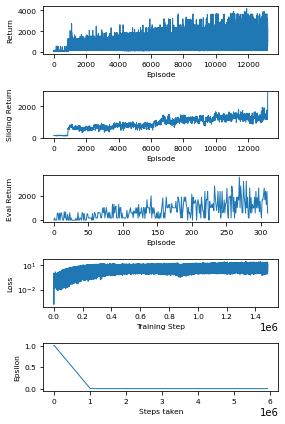

KeyboardInterrupt: 

In [112]:
agent.RGB_episode(50000000, 0, 0.05)


I stopped the training after ~6e6 steps and ~310 evaluation steps. I will reduce the minimum epsilon even further to see if this helps convergence.

In [ ]:
agent.epsilon_min = 0.05
agent.RGB_episode(50000000, 0, 0.05)

In [20]:
agent.behavior.toymodel = keras.models.load_model(runname+'_behavior')
agent.target.toymodel = keras.models.load_model(runname+'_target')

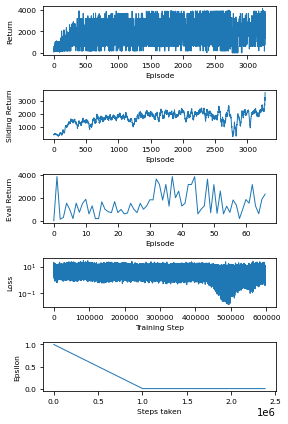

In [ ]:
agent.epsilon_max = 1.0
agent.epsilon_min = 0.02
agent.epsilon_lag = 10
agent.RGB_episode(50000000, 0, 0.05)

In [8]:
#Load the saved model and continue traning.

runname = "210612_1_SMB_DQN"
agent.behavior.toymodel = keras.models.load_model(runname+'_behavior')
agent.target.toymodel = keras.models.load_model(runname+'_target')

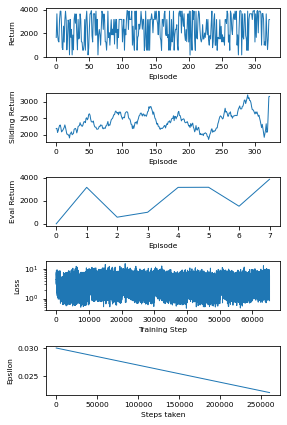

KeyboardInterrupt: 

In [23]:
#I increased the batch size to 64.
agent.batch_size = 64
agent.epsilon_max = 0.03
agent.epsilon_min = 0.02
agent.epsilon_lag = 10
agent.RGB_episode(50000000, 0, 0.02)